In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils, Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
import keras

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
# image specification
img_cols,img_rows=100,176
nb_frames = 16    # img_depth or number of frames used for each video
# CNN Training parameters
nb_classes = 27
channels = 2

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# integer encode
labels = pd.read_csv('E:\Jupyter\Project\jester-v1-labels.csv',sep=';',header=None,names=['Class'])     # reading the csv file
label_encoder = LabelEncoder()
labels['Label'] = label_encoder.fit_transform(labels['Class'])

#train
train = pd.read_csv('E:\Jupyter\Project\jester-v1-train.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = pd.read_csv('E:\Jupyter\Project\jester-v1-validation.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = temp["Label"].to_dict()

In [4]:
import random
def data_gen(train_list):
    while True:
        X_tr=[]
        label=[]
        for vid_ID in random.sample(train_list,128):
            frames = []
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/generated_images512_timeSampled/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/generated_images512_timeSampled/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                if frame_count < nb_frames:
                    pos = os.path.join(pos_dir,img_ID)
                    neg = os.path.join(neg_dir,img_ID)
                    p_img = cv2.imread(pos,0)
                    p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    n_img = cv2.imread(neg,0)
                    n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    frame = cv2.merge((p_img,n_img))
                    frames.append(frame)
                    frame_count+=1
                else:
                    break
            while frame_count < nb_frames:
                frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
                frame_count+=1
            input_img = np.array(frames)
            ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
            ipt=np.rollaxis(ipt,2,0)
            X_tr.append(ipt)
            label.append(labels_dict[vid_ID])

        X_tr_array = np.array(X_tr)   # convert the frames read into array

        Y_train = np_utils.to_categorical(label, nb_classes)

        yield X_tr_array,Y_train

In [5]:
print(next(data_gen(train["Video"].tolist()))[0].shape)

(128, 16, 100, 176, 2)


In [6]:
#low resolution network
weight_decay = 0.005
from keras import regularizers
model = Sequential()
model.add(MaxPooling3D(pool_size=(1, 2, 2),input_shape=(nb_frames,  img_cols, img_rows, channels)))

model.add(Conv3D(8,(5,5,5),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(32,(3,5,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64,(3,3,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 1, 4 )))



#model.add(Conv3D(128,3,3,3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
#border_mode='valid'))
#model.add(BatchNormalization())

model.add(Flatten())
#model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(nb_classes,kernel_initializer='normal',kernel_regularizer=regularizers.l2(weight_decay)))

model.add(Activation('softmax'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 16, 50, 88, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 46, 84, 8)     2008      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 12, 23, 42, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 19, 38, 32)    19232     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 9, 19, 32)      0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 7, 15, 64)      92224     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 3, 7, 3, 64)       0         
__________

In [8]:
import os
save_dir = os.path.join(os.getcwd(),'save_model')
print(os.getcwd())
model_name = "3DCNN+3LSTM_64_6_jester"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

E:\Jupyter\Project


In [9]:
sgd = SGD(lr=0.003,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])

In [10]:
nb_epoch =32
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit_generator(data_gen(train["Video"].tolist()[0:1500]),
                           validation_data=data_gen(train["Video"].tolist()[0:1500]),
                           steps_per_epoch=32,
                           validation_steps=1,
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/32
32/32 [==============================] - 40s 1s/step - loss: 10.6495 - acc: 0.0508 - val_loss: 9.8575 - val_acc: 0.0703

Epoch 00001: val_acc improved from -inf to 0.07031, saving model to E:\Jupyter\Project\save_model\3DCNN+3LSTM_64_6_jester
Epoch 2/32
32/32 [==============================] - 26s 798ms/step - loss: 9.7976 - acc: 0.0554 - val_loss: 9.7277 - val_acc: 0.0781

Epoch 00002: val_acc improved from 0.07031 to 0.07812, saving model to E:\Jupyter\Project\save_model\3DCNN+3LSTM_64_6_jester
Epoch 3/32
32/32 [==============================] - 27s 833ms/step - loss: 9.6740 - acc: 0.0620 - val_loss: 9.6094 - val_acc: 0.1016

Epoch 00003: val_acc improved from 0.07812 to 0.10156, saving model to E:\Jupyter\Project\save_model\3DCNN+3LSTM_64_6_jester
Epoch 4/32
32/32 [==============================] - 26s 806ms/step - loss: 9.5470 - acc: 0.0740 - val_loss: 9.4740 - val_acc: 0.1172

Epoch 00004: val_acc improved from 0.10156 to 0.11719, saving model to E:\Jupyter\Project\save

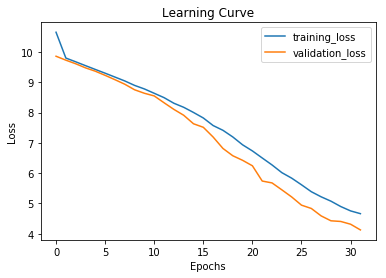

In [11]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

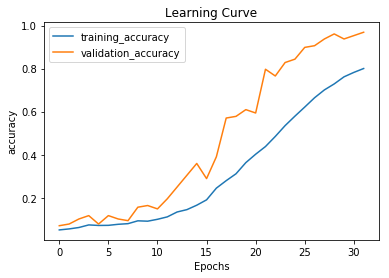

In [12]:
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [13]:
from keras.models import Model, load_model
model1_name = "3DCNN+3LSTM_64_6_jester"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)


In [15]:
# Training data

X_tr=[]           # variable to store entire dataset
label=[]

from tqdm import tqdm

ls_path = os.path.join("E:/Jupyter/Project/generated_images512_timeSampled")

for vid_ID in tqdm(train["Video"].tolist()[0:1500]):
    frames = []
    frame_count=0
    pos_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    neg_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    for img_ID in sorted(os.listdir(pos_dir)):
        if frame_count < nb_frames:
            pos = os.path.join(pos_dir,img_ID)
            neg = os.path.join(neg_dir,img_ID)
            p_img = cv2.imread(pos,0)
            p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            n_img = cv2.imread(neg,0)
            n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            frame = cv2.merge((p_img,n_img))
            frames.append(frame)
            frame_count+=1
        else:
            break
    while frame_count < nb_frames:
        frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
        frame_count+=1
    input_img = np.array(frames)
    ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
    ipt=np.rollaxis(ipt,2,0)
    X_tr.append(ipt)
    label.append(labels_dict[vid_ID])

print (ipt.shape)
num_samples = len(X_tr) 
print (num_samples)
X_tr_array = np.array(X_tr)   # convert the frames read into array

train_data = [X_tr_array,label]
(X_train, y_train) = (train_data[0],train_data[1])
train_set = np.zeros((num_samples, nb_frames, img_cols,img_rows,2))
for h in range(num_samples):
    train_set[h][:][:][:][:]=X_train[h,:,:,:]
Y_train = np_utils.to_categorical(y_train, nb_classes)
X_train_new, X_val_new, y_train_new,y_val_new = train_test_split(train_set, Y_train, test_size=0.2, random_state=20)

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 191.18it/s]


(16, 100, 176, 2)
1500


In [16]:
test_pred =model1.predict(X_train_new[50:70])
result = np.argmax(test_pred, axis =1)
print(result)

[18  5  2 18  2 19 18  3 26  8  2 26  0  5  2 16  3 26 14 20]


In [17]:
img_array = X_train_new[50]
from sklearn.metrics import confusion_matrix
met = confusion_matrix(np.argmax(y_val_new,axis =1), np.argmax(model1.predict(X_val_new),axis =1))
print(met)

[[5 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 2 1 0 0 0 0 1 1]
 [2 2 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [0 0 7 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [1 1 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 1 2 2]
 [1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 4 1 0 2 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [3 1 0 0 0 1 3 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [2 0 1 1 1 0 0 2 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0]
 [0 0 0 0 1 0 0 1 5 0 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 2 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 1 0 1 0 0 4 0 0 0 0 2 0 0 0 0 0 0 0 0 1 2]
 [1 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 1 0 1 1 0 1 0 0 1]
 [0 2 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1]
 [1 0 1 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 3 0 0 1 1 1 0 0 0 0 0 0]
 [2 0 0 2 0 0 0 1 1 0 0 1 0 0 0 0 6 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 0 0 0 0 0 1 1 1 0 0

In [18]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

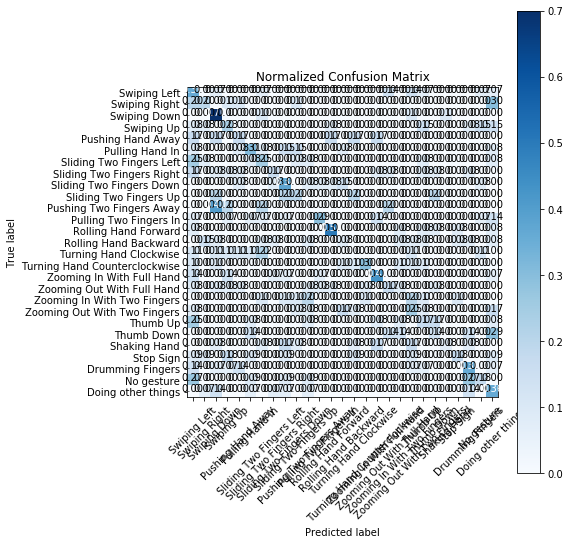

In [19]:
confusion_matrix_plot(met, classes=labels["Class"].tolist())

In [20]:
from keras.models import Model, load_model
model2_name = "3DCNN+3LSTM_64_6_jester"
#model2_name = "3DCNN_LRN_300_6_jester"
#model2_name = "3DCNN_HRN_300_6_jester"
model2_path = os.path.join(save_dir, model2_name)
model2 = load_model(model2_path)
met = confusion_matrix(np.argmax(y_val_new,axis =1), np.argmax(model2.predict(X_val_new),axis =1))
print(met)

[[5 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 2 1 0 0 0 0 1 1]
 [2 2 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [0 0 7 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [1 1 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 1 2 2]
 [1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 4 1 0 2 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [3 1 0 0 0 1 3 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [2 0 1 1 1 0 0 2 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0]
 [0 0 0 0 1 0 0 1 5 0 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 2 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 1 0 1 0 0 4 0 0 0 0 2 0 0 0 0 0 0 0 0 1 2]
 [1 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 1 0 1 1 0 1 0 0 1]
 [0 2 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1]
 [1 0 1 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 3 0 0 1 1 1 0 0 0 0 0 0]
 [2 0 0 2 0 0 0 1 1 0 0 1 0 0 0 0 6 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 0 0 0 0 0 1 1 1 0 0

In [21]:
model2.evaluate(X_val_new,y_val_new)

300/300 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 6ms/step


[6.88148998896281, 0.2533333335320155]

In [22]:
for i in range(10):
    we=(i+1)/10
    we_2=1-we
    met = confusion_matrix(np.argmax(y_val_new,axis =1), np.argmax(we*model2.predict(X_val_new)+we_2*model1.predict(X_val_new),axis =1))
    print((met[0,0]+met[1,1]+met[2,2]+met[3,3]+met[4,4]+met[5,5])/360)

0.06111111111111111
0.06111111111111111
0.06111111111111111
0.06111111111111111
0.06111111111111111
0.06111111111111111
0.06111111111111111
0.06111111111111111
0.06111111111111111
0.06111111111111111
